In [ ]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Fraud_Detection") \
    .getOrCreate()

from pathlib import Path
Path.cwd()

24/07/26 13:57:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


PosixPath('/Users/phuong/Desktop/Flexon-Job-preparing/Banking/Projects/CC_Fraud_detection')

## Importing packages and data


In [2]:
# !pip install xgboost
# from xgboost import XGBClassifier

import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

import matplotlib.pyplot  as plt

from pathlib import Path
Path.cwd()

2024-07-26 13:57:38.866417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


PosixPath('/Users/phuong/Desktop/Flexon-Job-preparing/Banking/Projects/CC_Fraud_detection')

In [74]:
path = '/Users/phuong/Desktop/Flexon-Job-preparing/Banking/Projects/CC_Fraud_detection/creditcard.csv'
data = spark.read.format("csv").options(dropInvalid = False, header= True).load(path)
data = data.toPandas()
X = data.iloc[:,:-1].astype('float32') 
y = data.Class.astype('int')
X.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998


##### For fraud detection with imbalanced dataset, we can use ensemble method and specify the class weights prior training.
##### SVM, RandomForestClassifer, XGBoostClassifer will be used in this project.

##  Preparing the data

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [137]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [139]:
from sklearn.utils import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced',y_train=y_train)

class_weights = {y_train.value_counts().index[0]: y_train.value_counts()[0], 
                 y_train.value_counts().index[1]: y_train.value_counts()[1]}




In [102]:
rd = RandomForestClassifier(class_weight=class_weights)
rd.fit(X_train,y_train)



RandomForestClassifier(class_weight={0: 190477, 1: 343})

In [182]:
threshold = 0.2
y_prob = rd.predict_proba(X_test)[:,1]
y_pred_adjusted = (y_prob >= threshold).astype(int)

print(accuracy_score(y_test, y_pred_adjusted))
y_pred_adjusted


0.9995365298727564


array([0, 0, 0, ..., 0, 0, 0])

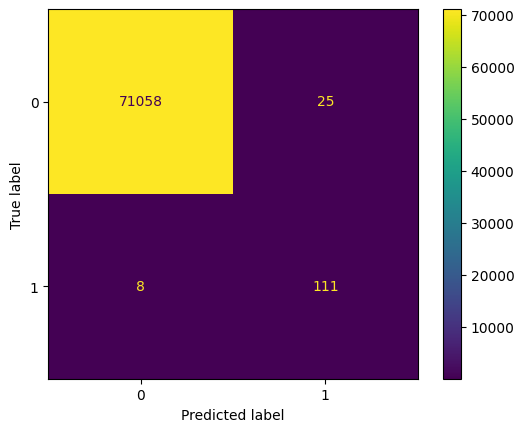

In [179]:
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## GridSearchCV

We can skip this step since the model predicts well.

In [181]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# class_weights = {y_val.value_counts().index[0]: y_val.value_counts()[0], 
#                  y_val.value_counts().index[1]: y_val.value_counts()[1]}

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf = RandomForestClassifier(class_weight=class_weights)
# grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_val, y_val)
# best_rf = grid_search.best_estimator_
# best_rf

## Model validataion

In [142]:
from sklearn.model_selection import KFold, cross_val_score


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_classifier, X_val, y_val, cv=kf, scoring='accuracy')
print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')
print(f'Standard deviation: {scores.std()}')

Cross-validation scores: [0.9992978  0.99957868 0.9991573  0.99978933 0.99936798]
Mean accuracy: 0.9994382180269186
Standard deviation: 0.000222067566325615


KFold proves that the model predicts the new data very well. 